# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [5]:
#extracting only transactions done by the user

transaction = transcript[transcript.event=="transaction"]

transaction.head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [6]:
#Splitting the str to columns

temp = transaction.value.astype(str).str.split("{'amount': ", 1, expand=True)
temp.columns = ['temp', 'amount']
temp[['amount', 'temp2']] = temp.amount.astype(str).str.split("}", 1, expand=True)
temp = temp.drop(['temp', 'temp2'], axis=1)
temp = temp.astype('float64')

transaction = pd.concat([transaction, temp], axis=1)

In [7]:
transaction.head()

,person,event,value,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97


### Clustering of Starbucks Users Project

### Description of the project

Clustering of the users based on similar characteristics/features. Based on that clustering we can figure similar offers that worked for similar users in the past.  

#### Cleaning the Data

We shall now clean the data to remove any NaN values


In [8]:
print("Percentage of NaN Values are:", profile.income.isna().sum() / profile.income.count() * 100)

Percentage of NaN Values are: 14.67116357504216


In [9]:
profile.income = profile.income.fillna(0)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,0.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,0.0


In [10]:
set(profile.gender)

{'F', 'M', None, 'O'}

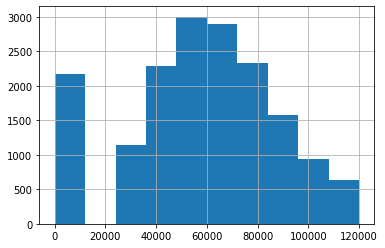

In [11]:
profile.income.hist();

In [12]:
def clean_data(df, string):
    """
    Takes transcript dataframe and returns cleaned offer_id dataframe
    
    Inputs 
    df: pd.DataFrame
    string: str, event which needs to be cleaned
    
    Outputs
    cleaned_df: pd.DataFrame
    """
    temp = df[df.event==string].value.astype(str).str.split("{'offer id': ", 1, expand=True)
    temp.columns = ['temp', 'offer_id']
    temp[['offer_id', 'temp2']] = temp.offer_id.astype(str).str.split("}", 1, expand=True)
    temp = temp.drop(['temp', 'temp2'], axis=1)
    clean_df = pd.concat([df[df.event==string], temp], axis=1)
    return clean_df

In [13]:
offer_received = clean_data(transcript, "offer received")
offer_received = offer_received.drop(['event', 'value'], axis=1)
offer_received.head()

,person,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,'9b98b8c7a33c4b65b9aebfe6a799e6d9'
1,a03223e636434f42ac4c3df47e8bac43,0,'0b1e1539f2cc45b7b9fa7c272da2e1d7'
2,e2127556f4f64592b11af22de27a7932,0,'2906b810c7d4411798c6938adc9daaa5'
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,'fafdcd668e3743c1bb461111dcafc2a4'
4,68617ca6246f4fbc85e91a2a49552598,0,'4d5c57ea9a6940dd891ad53e9dbe8da0'


In [14]:
temp = transcript[transcript.event=="offer completed"].value.astype(str).str.split("{'offer_id': ", 1, expand=True)
temp.columns = ['temp', 'offer_id']
temp[['offer_id', 'temp2']] = temp.offer_id.astype(str).str.split(",", 1, expand=True)
temp[['temp3', 'reward']] = temp.temp2.astype(str).str.split("'reward': ", 1, expand=True)
temp[['reward', 'temp4']] = temp.reward.astype(str).str.split("}", 1, expand=True)
temp = temp.drop(['temp', 'temp2', 'temp3', 'temp4'], axis=1)
offer_completed = pd.concat([transcript[transcript.event=="offer completed"], temp], axis=1)

In [15]:
offer_completed = offer_completed.drop(['event', 'value'], axis=1)
offer_completed['reward'] = offer_completed.reward.astype('float64')
offer_completed.head()

,person,time,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,'2906b810c7d4411798c6938adc9daaa5',2.0
12672,fe97aa22dd3e48c8b143116a8403dd52,0,'fafdcd668e3743c1bb461111dcafc2a4',2.0
12679,629fc02d56414d91bca360decdfa9288,0,'9b98b8c7a33c4b65b9aebfe6a799e6d9',5.0
12692,676506bad68e4161b9bbaffeb039626b,0,'ae264e3637204a6fb9bb56bc8210ddfd',10.0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,'4d5c57ea9a6940dd891ad53e9dbe8da0',10.0


In [39]:
com_offer_com_temp1 = pd.pivot_table(offer_completed, values='reward', index=['person'],
                                    aggfunc=np.mean)
com_offer_com_temp2 = pd.pivot_table(offer_completed, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)
com_offer_completed = pd.concat([com_offer_com_temp1, com_offer_com_temp2], axis=1)
com_offer_completed = com_offer_completed.reset_index()
com_offer_completed.columns = ['id','avg_reward','offers_done']
com_offer_completed.head()

,id,avg_reward,offers_done
0,0009655768c64bdeb2e877511632db8f,3.000000,3
1,0011e0d4e6b944f998e987f904e8c1e5,4.333333,3
2,0020c2b971eb4e9188eac86d93036a77,4.666667,3
3,0020ccbbb6d84e358d3414a3ff76cffd,4.333333,3
4,003d66b6608740288d6cc97a6903f4f0,3.000000,3


In [40]:
com_offer_rec = pd.pivot_table(offer_received, values='offer_id', index=['person'],
                                    aggfunc=np.count_nonzero)
com_offer_rec = com_offer_rec.reset_index()
com_offer_rec.columns = ['id','offers_rcv']
com_offer_rec.head()

,id,offers_rcv
0,0009655768c64bdeb2e877511632db8f,5
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,5
3,0020c2b971eb4e9188eac86d93036a77,5
4,0020ccbbb6d84e358d3414a3ff76cffd,4


In [18]:
#Combining the transaction data
com_tran_temp1 = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.sum)
com_tran_temp2 = pd.pivot_table(transaction, values='amount', index=['person'], 
                         aggfunc=np.count_nonzero)
com_tran_temp2.columns = ['count']
com_tran = pd.concat([com_tran_temp1, com_tran_temp2], axis=1)
com_tran = com_tran.reset_index()
com_tran

,person,amount,count
0,0009655768c64bdeb2e877511632db8f,127.60,8.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,8.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0
...,...,...,...
16573,fff3ba4757bd42088c044ca26d73817a,580.98,11.0
16574,fff7576017104bcc8677a8d63322b5e1,29.94,6.0
16575,fff8957ea8b240a6b5e634b6ee8eafcf,12.15,5.0
16576,fffad4f4828548d1b5583907f2e9906b,88.83,12.0


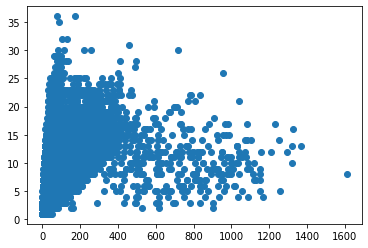

In [19]:
plt.scatter(com_tran['amount'], com_tran['count']);

#### Combining the Data

We shall now combine the data for cluster analysis

In [20]:
com_tran.columns = ['id', 'amount', 'count']
com_tran.head()

,id,amount,count
0,0009655768c64bdeb2e877511632db8f,127.60,8.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,8.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0


In [41]:
comb_df = pd.merge(profile, com_tran, on='id')
comb_df = pd.merge(comb_df, com_offer_rec, on='id')
comb_df = pd.merge(comb_df, com_offer_completed, on='id')
comb_df.head()

,gender,age,id,became_member_on,income,amount,count,offers_rcv,avg_reward,offers_done
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9.0,5,2.500000,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3.0,2,5.000000,1
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7.0,4,6.666667,3
3,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3.0,4,3.500000,2
4,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3.0,6,3.800000,5


In [42]:
#add a column to compute total offers_completed
comb_df['perc_comp'] = comb_df['offers_done']/comb_df['offers_rcv']
comb_df.head()

,gender,age,id,became_member_on,income,amount,count,offers_rcv,avg_reward,offers_done,perc_comp
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0.0,20.40,9.0,5,2.500000,2,0.400000
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3.0,2,5.000000,1,0.500000
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7.0,4,6.666667,3,0.750000
3,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3.0,4,3.500000,2,0.500000
4,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3.0,6,3.800000,5,0.833333


#### Visualize the dataframe


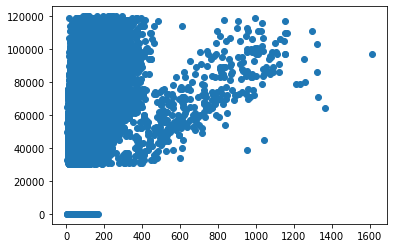

In [43]:
plt.scatter(comb_df['amount'], comb_df['income']);

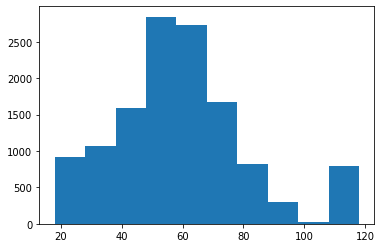

In [44]:
plt.hist(comb_df['age']);

#### Removing outliers

As we can see in the above histogram, there are around 2000 users whose age is more than 100. Looks like error in data and we will drop the users with age more than 100.

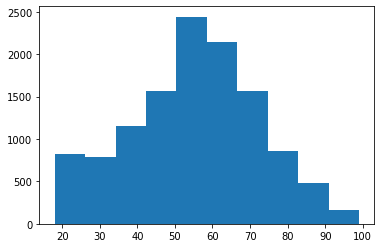

In [45]:
clean_df = comb_df[comb_df['age']<100]
plt.hist(clean_df['age']);

In [46]:
clean_df.head()

,gender,age,id,became_member_on,income,amount,count,offers_rcv,avg_reward,offers_done,perc_comp
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3.0,2,5.000000,1,0.500000
2,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7.0,4,6.666667,3,0.750000
3,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3.0,4,3.500000,2,0.500000
4,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3.0,6,3.800000,5,0.833333
8,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4.0,3,2.000000,1,0.333333


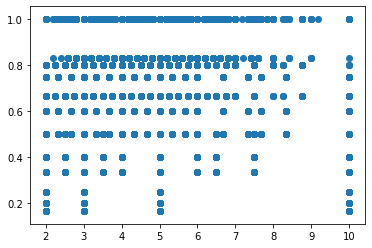

In [67]:
plt.scatter(clean_df['avg_reward'], clean_df['perc_comp']);

### Supervised Machine Learning to predict amount to be spent in Starbucks, average reward on offers and percentage of offers completed
Now we shall use ML to predict three variables i.e. amount spent, average reward and probability user will complete an offer

#### We will use Support Vector Machines to predict our three variables

In [86]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [73]:
X = np.array(clean_df.drop(['id', 'became_member_on','amount','avg_reward','offers_rcv','offers_done'
                           , 'perc_comp'], axis=1))
y1 = clean_df['amount']
y2 = clean_df['avg_reward']
y3 = clean_df['perc_comp']

In [76]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, 
                                                                                            y2, y3, 
                                                                                            test_size=0.30, random_state=42)

In [109]:
regr1 = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.1))
regr1.fit(X_train, y1_train)
y1_hat = regr1.predict(X_test)

In [110]:
regr2 = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.1))
regr2.fit(X_train, y2_train)
y2_hat = regr.predict(X_test)

In [111]:
regr3 = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.1))
regr3.fit(X_train, y3_train)
y3_hat = regr3.predict(X_test)

In [112]:
print(np.sqrt(regr1.score(X_test, y1_test)))
print(np.sqrt(regr2.score(X_test, y2_test)))
print(np.sqrt(regr3.score(X_test, y3_test)))


0.5702262024111281
0.06883432792848113
0.4842954829804965


#### Clustering of users

We will now try to divide our customers into three distinct clusters using KMeans clustering. But first we need to transform our data points so that features remain unbiased.

In [54]:
dummy = pd.get_dummies(clean_df['gender'])
clean_df = pd.concat([clean_df,dummy], axis=1)
clean_df = clean_df.drop('gender', axis=1)

In [55]:
clean_df.tail()

,age,id,became_member_on,income,amount,count,offers_rcv,avg_reward,offers_done,perc_comp,F,M,O
12769,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0,143.75,15.0,5,3.750000,4,0.800000,1,0,0
12770,60,cb23b66c56f64b109d673d5e56574529,20180505,113000.0,115.59,5.0,3,2.000000,1,0.333333,0,1,0
12771,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,25.97,7.0,3,5.000000,1,0.333333,0,1,0
12772,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,189.67,14.0,3,8.333333,3,1.000000,1,0,0
12773,62,e4052622e5ba45a8b96b59aba68cf068,20170722,82000.0,143.02,6.0,4,4.000000,2,0.500000,1,0,0


In [56]:
X = np.array(clean_df.drop(['id', 'became_member_on'], axis=1))
X

array([[5.5000e+01, 1.1200e+05, 7.7010e+01, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.5000e+01, 1.0000e+05, 1.5927e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.8000e+01, 7.0000e+04, 5.7730e+01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [6.1000e+01, 7.2000e+04, 2.5970e+01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [8.3000e+01, 5.0000e+04, 1.8967e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.2000e+01, 8.2000e+04, 1.4302e+02, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [57]:
X_train, X_test = train_test_split(X, test_size=0.30, random_state=42)
X_train

array([[1.8000e+01, 4.1000e+04, 1.3298e+02, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [4.5000e+01, 5.3000e+04, 1.3833e+02, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.6000e+01, 7.6000e+04, 1.1308e+02, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [5.2000e+01, 5.4000e+04, 1.4390e+01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [6.5000e+01, 3.1000e+04, 4.3390e+01, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [5.4000e+01, 6.7000e+04, 2.6126e+02, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [58]:
#Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

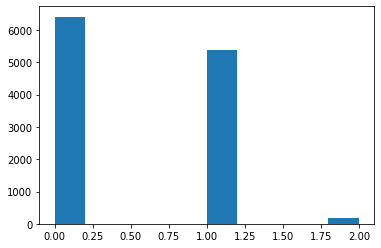

In [59]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled)
plt.hist(kmeans.labels_);

In [60]:
kmeans.get_params

<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)>

In [61]:
kmeans.labels_

array([1, 1, 0, ..., 0, 1, 1], dtype=int32)

In [62]:
y = kmeans.fit_predict(X)

No handles with labels found to put in legend.


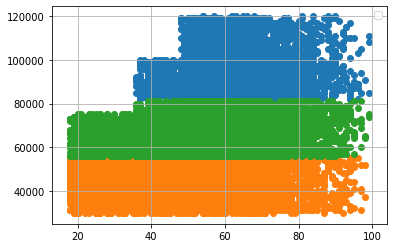

In [35]:
plt.scatter(X[y == 0, 0], X[y == 0,1])
plt.scatter(X[y == 1, 0], X[y == 1,1])
plt.scatter(X[y == 2, 0], X[y == 2,1])
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [63]:
clean_df['label'] = y
clean_df.head()

,age,id,became_member_on,income,amount,count,offers_rcv,avg_reward,offers_done,perc_comp,F,M,O,label
1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,77.01,3.0,2,5.000000,1,0.500000,1,0,0,1
2,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,159.27,7.0,4,6.666667,3,0.750000,1,0,0,1
3,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,57.73,3.0,4,3.500000,2,0.500000,0,1,0,2
4,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,36.43,3.0,6,3.800000,5,0.833333,0,1,0,0
8,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,15.62,4.0,3,2.000000,1,0.333333,0,1,0,0


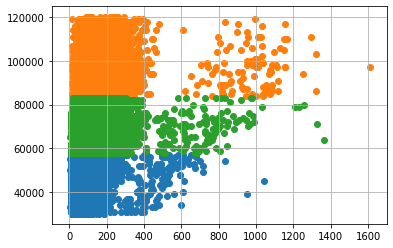

In [64]:
plt.scatter(clean_df.amount[clean_df['label']==0], clean_df.perc_comp[clean_df['label']==0])
plt.scatter(clean_df.amount[clean_df['label']==1], clean_df.perc_comp[clean_df['label']==1])
plt.scatter(clean_df.amount[clean_df['label']==2], clean_df.perc_comp[clean_df['label']==2])
plt.grid()
plt.show();